In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import tensorflow as tf
from tensorflow import keras
import warnings
import shap
import Lib.Functions as fc
shap.initjs()
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/Adaptive Engine/Lib/Functions.ipynb


In [2]:
df = pd.read_csv('Marketing-Customer-Value-Analysis.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
features_collected = ['Customer Lifetime Value', 
                      'Income', 
                      'Monthly Premium Auto',
                      'Months Since Policy Inception', 
                      'Total Claim Amount']
label = 'Response'

In [6]:
df['Response'] = df['Response'].map(lambda x: 1 if x == 'Yes' else 0)

In [7]:
X = df[features_collected]
y = df[label]

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [8]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 200)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

1.0

In [9]:
cross_val_score(xgb_model, X_train, y_train)

array([0.99124088, 0.9919708 , 0.99489051, 0.99416058, 0.9919708 ])

In [10]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9947

* Confusion Matrix of Test: 
[[1945   12]
 [   0  327]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1957
           1       0.96      1.00      0.98       327

    accuracy                           0.99      2284
   macro avg       0.98      1.00      0.99      2284
weighted avg       0.99      0.99      0.99      2284



In [11]:
import lightgbm as lgbm

lgb_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 200)
lgb_model = lgb_clf.fit(X_train, y_train)

lgb_model.score(X_train, y_train)

0.9998540145985402

In [12]:
cross_val_score(lgb_model, X_train, y_train)

array([0.99416058, 0.99270073, 0.99051095, 0.9919708 , 0.98759124])

In [13]:
fc.eval_clf_testset(lgb_model, X_test, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9947

* Confusion Matrix of Test: 
[[1950    7]
 [   5  322]]

* Classification Report of Test: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1957
           1       0.98      0.98      0.98       327

    accuracy                           0.99      2284
   macro avg       0.99      0.99      0.99      2284
weighted avg       0.99      0.99      0.99      2284



In [14]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

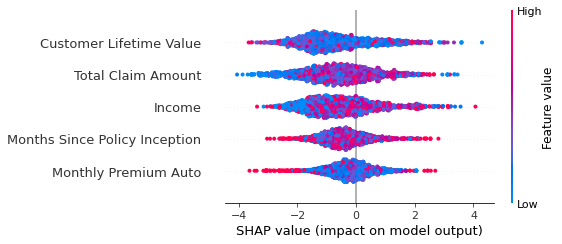

In [15]:
shap.summary_plot(shap_values, X_test)

In [16]:
explainer.expected_value

-2.1017573

In [24]:
shap_values.shape

(2284, 5)

In [18]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :])

In [19]:
xgb_model.predict_proba(X_test.iloc[0, :].values.reshape(1, -1))

array([[0.9832763, 0.0167237]], dtype=float32)

In [20]:
shap.force_plot(explainer.expected_value, shap_values[100, :], X_test.iloc[100, :])

In [25]:
xgb_model.predict_proba(X_test.iloc[100, :].values.reshape(1, -1))

array([[0.03359312, 0.9664069 ]], dtype=float32)

In [10]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

NameError: name 'explainer' is not defined

In [27]:
ex = shap.KernelExplainer(xgb_model.predict_proba, X_test)
shap_kernel = ex.shap_values(X_test)

Using 2284 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2284 [00:00<?, ?it/s]

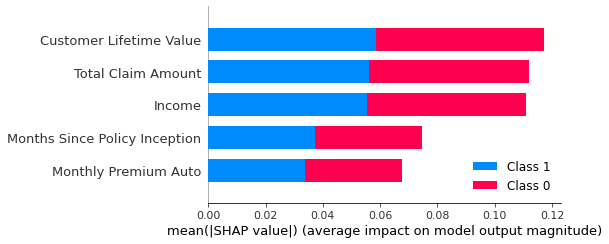

In [30]:
shap.summary_plot(shap_kernel, X_test)

In [31]:
ex.expected_value

array([0.84844665, 0.15155335])

In [32]:
shap.force_plot(ex.expected_value[0], shap_kernel[0][0, :], X_test.iloc[0, :])

In [33]:
shap.force_plot(ex.expected_value[1], shap_kernel[1][100, :], X_test.iloc[100, :])

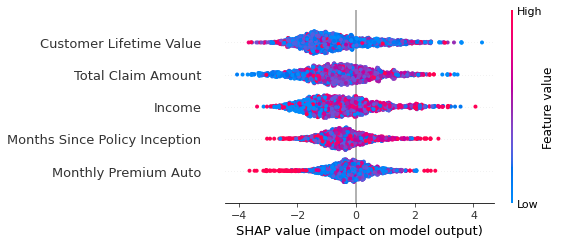

In [34]:
shap.summary_plot(shap_values, X_test)

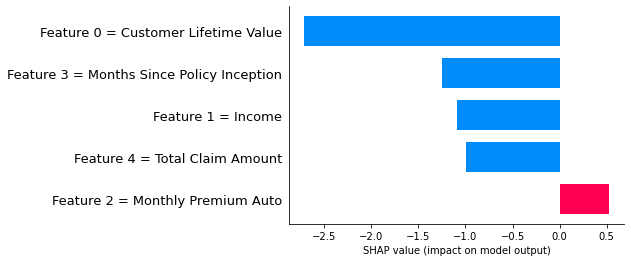

In [35]:
shap.bar_plot(shap_values[146], X_test)

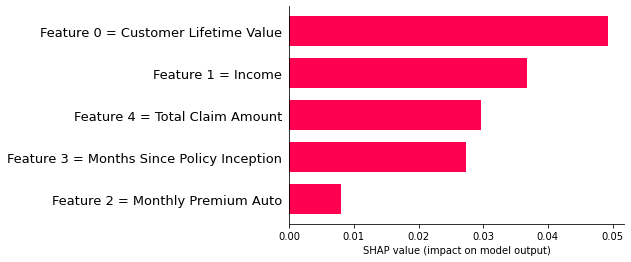

In [36]:
shap.bar_plot(shap_kernel[0][146, :], X_test)

In [37]:
xgb_model.predict(X_test.iloc[146, :].values.reshape(1, -1))

array([0])

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, input_dim = X_train_scaled.shape[1], activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

tf_model.compile(loss = 'binary_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])

his = tf_model.fit(X_train_scaled, y_train,
                   validation_data = (X_test_scaled, y_test),
                   epochs = 200,
                   verbose = 2)

2022-07-25 12:00:20.583677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
215/215 - 2s - loss: 0.4173 - accuracy: 0.8533 - val_loss: 0.4078 - val_accuracy: 0.8568 - 2s/epoch - 8ms/step
Epoch 2/200
215/215 - 1s - loss: 0.3978 - accuracy: 0.8564 - val_loss: 0.3989 - val_accuracy: 0.8568 - 954ms/epoch - 4ms/step
Epoch 3/200
215/215 - 1s - loss: 0.3893 - accuracy: 0.8577 - val_loss: 0.3882 - val_accuracy: 0.8577 - 939ms/epoch - 4ms/step
Epoch 4/200
215/215 - 1s - loss: 0.3849 - accuracy: 0.8575 - val_loss: 0.3863 - val_accuracy: 0.8568 - 932ms/epoch - 4ms/step
Epoch 5/200
215/215 - 1s - loss: 0.3761 - accuracy: 0.8578 - val_loss: 0.3704 - val_accuracy: 0.8573 - 944ms/epoch - 4ms/step
Epoch 6/200
215/215 - 1s - loss: 0.3696 - accuracy: 0.8569 - val_loss: 0.3753 - val_accuracy: 0.8555 - 932ms/epoch - 4ms/step
Epoch 7/200
215/215 - 1s - loss: 0.3603 - accuracy: 0.8569 - val_loss: 0.3607 - val_accuracy: 0.8573 - 941ms/epoch - 4ms/step
Epoch 8/200
215/215 - 1s - loss: 0.3532 - accuracy: 0.8575 - val_loss: 0.3464 - val_accuracy: 0.8590 - 932ms/epoch - 4ms/

Epoch 66/200
215/215 - 1s - loss: 0.0641 - accuracy: 0.9727 - val_loss: 0.1528 - val_accuracy: 0.9418 - 946ms/epoch - 4ms/step
Epoch 67/200
215/215 - 1s - loss: 0.0762 - accuracy: 0.9699 - val_loss: 0.1247 - val_accuracy: 0.9479 - 931ms/epoch - 4ms/step
Epoch 68/200
215/215 - 1s - loss: 0.0616 - accuracy: 0.9746 - val_loss: 0.1128 - val_accuracy: 0.9553 - 994ms/epoch - 5ms/step
Epoch 69/200
215/215 - 1s - loss: 0.0629 - accuracy: 0.9758 - val_loss: 0.1415 - val_accuracy: 0.9470 - 1s/epoch - 5ms/step
Epoch 70/200
215/215 - 1s - loss: 0.0710 - accuracy: 0.9708 - val_loss: 0.1361 - val_accuracy: 0.9514 - 925ms/epoch - 4ms/step
Epoch 71/200
215/215 - 1s - loss: 0.0623 - accuracy: 0.9749 - val_loss: 0.1248 - val_accuracy: 0.9527 - 914ms/epoch - 4ms/step
Epoch 72/200
215/215 - 1s - loss: 0.0625 - accuracy: 0.9762 - val_loss: 0.1129 - val_accuracy: 0.9593 - 907ms/epoch - 4ms/step
Epoch 73/200
215/215 - 1s - loss: 0.0552 - accuracy: 0.9781 - val_loss: 0.1389 - val_accuracy: 0.9562 - 908ms/epoc

Epoch 131/200
215/215 - 1s - loss: 0.0376 - accuracy: 0.9855 - val_loss: 0.1488 - val_accuracy: 0.9571 - 1s/epoch - 6ms/step
Epoch 132/200
215/215 - 1s - loss: 0.0416 - accuracy: 0.9842 - val_loss: 0.1418 - val_accuracy: 0.9584 - 1s/epoch - 7ms/step
Epoch 133/200
215/215 - 2s - loss: 0.0331 - accuracy: 0.9877 - val_loss: 0.1169 - val_accuracy: 0.9650 - 2s/epoch - 7ms/step
Epoch 134/200
215/215 - 2s - loss: 0.0282 - accuracy: 0.9888 - val_loss: 0.1436 - val_accuracy: 0.9623 - 2s/epoch - 8ms/step
Epoch 135/200
215/215 - 2s - loss: 0.0451 - accuracy: 0.9857 - val_loss: 0.1329 - val_accuracy: 0.9532 - 2s/epoch - 8ms/step
Epoch 136/200
215/215 - 1s - loss: 0.0312 - accuracy: 0.9886 - val_loss: 0.1290 - val_accuracy: 0.9610 - 1s/epoch - 7ms/step
Epoch 137/200
215/215 - 1s - loss: 0.0329 - accuracy: 0.9877 - val_loss: 0.1595 - val_accuracy: 0.9562 - 1s/epoch - 6ms/step
Epoch 138/200
215/215 - 1s - loss: 0.0329 - accuracy: 0.9870 - val_loss: 0.1448 - val_accuracy: 0.9615 - 1s/epoch - 7ms/step


Epoch 196/200
215/215 - 1s - loss: 0.0350 - accuracy: 0.9873 - val_loss: 0.1029 - val_accuracy: 0.9702 - 935ms/epoch - 4ms/step
Epoch 197/200
215/215 - 1s - loss: 0.0161 - accuracy: 0.9928 - val_loss: 0.1100 - val_accuracy: 0.9742 - 930ms/epoch - 4ms/step
Epoch 198/200
215/215 - 1s - loss: 0.0376 - accuracy: 0.9888 - val_loss: 0.1193 - val_accuracy: 0.9628 - 917ms/epoch - 4ms/step
Epoch 199/200
215/215 - 1s - loss: 0.0193 - accuracy: 0.9926 - val_loss: 0.1566 - val_accuracy: 0.9667 - 911ms/epoch - 4ms/step
Epoch 200/200
215/215 - 1s - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.1444 - val_accuracy: 0.9593 - 912ms/epoch - 4ms/step


In [42]:
deep_ex = shap.DeepExplainer(tf_model, X_test_scaled)

In [43]:
deep_shap = deep_ex.shap_values(X_test_scaled)

In [44]:
shap.force_plot(np.array(deep_ex.expected_value[0]).tolist(), deep_shap[0][100, :], X_test_scaled[100, :],
                feature_names = X_test.columns)

In [45]:
np.array(deep_ex.expected_value[0])

array(0.15875925, dtype=float32)

In [46]:
deep_shap[0][100, :]

array([0.05055551, 0.13635398, 0.31092263, 0.21948925, 0.12199492])

In [47]:
X_test_scaled[100, :]

array([-0.35041816, -1.23802292,  1.73227652, -1.5385922 ,  2.01615196])

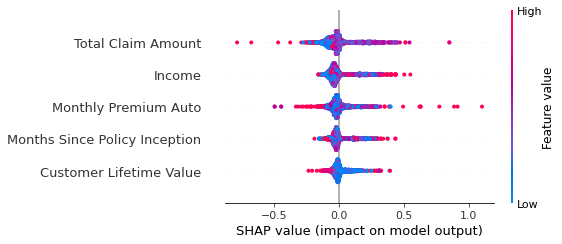

In [48]:
shap.summary_plot(deep_shap[0], X_test_scaled, feature_names = X_test.columns)